In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale
from statsmodels.tools.tools import add_constant

%matplotlib inline
tracts_data_path = 'data/features.csv'

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dtypes = {'GEOID' : str,
          'place_geoid' : str,
          'state' : str,
          'county' : str}

df = pd.read_csv(tracts_data_path, encoding='utf-8', dtype=dtypes)
df = df.rename(columns={'GEOID' : 'tract'}).set_index('tract')
assert df.index.is_unique

In [3]:
print(len(df))
df.head()

12328


,land_area,place_geoid,place_name,total_pop,median_age,prop_65_older,prop_hispanic,prop_white,prop_black,prop_asian,...,"Salt Lake City, UT","San Antonio, TX","San Diego, CA","San Francisco, CA","San Jose, CA","Seattle, WA","St. Louis, MO","Tampa, FL","Virginia Beach, VA","Washington, DC"
tract,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,0.116,0.046,0.171,0.785,0.000,...,0,0,0,0,0,0,0,0,0,0
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,0.074,0.180,0.046,0.672,0.084,...,0,0,0,0,0,0,0,0,0,0
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.093,0.007,0.079,0.908,0.000,...,0,0,0,0,0,0,0,0,0,0
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,0.092,0.014,0.050,0.929,0.000,...,0,0,0,0,0,0,0,0,0,0
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,0.103,0.025,0.000,0.977,0.000,...,0,0,0,0,0,0,0,0,0,0


In [4]:
str(sorted(df.columns.tolist()))

"['Atlanta, GA', 'Austin, TX', 'Baltimore, MD', 'Birmingham, AL', 'Boston, MA', 'Buffalo, NY', 'Charlotte, NC', 'Chicago, IL', 'Cincinnati, OH', 'Cleveland, OH', 'Columbus, OH', 'Dallas, TX', 'Denver, CO', 'Detroit, MI', 'Hartford, CT', 'Houston, TX', 'Indianapolis, IN', 'Jacksonville, FL', 'Kansas City, MO', 'Las Vegas, NV', 'Los Angeles, CA', 'Louisville, KY', 'Memphis, TN', 'Miami, FL', 'Milwaukee, WI', 'Minneapolis, MN', 'Nashville, TN', 'New Orleans, LA', 'New York, NY', 'Oklahoma City, OK', 'Orlando, FL', 'Philadelphia, PA', 'Phoenix, AZ', 'Pittsburgh, PA', 'Portland, OR', 'Providence, RI', 'Raleigh, NC', 'Richmond, VA', 'Riverside, CA', 'Sacramento, CA', 'Salt Lake City, UT', 'San Antonio, TX', 'San Diego, CA', 'San Francisco, CA', 'San Jose, CA', 'Seattle, WA', 'St. Louis, MO', 'Tampa, FL', 'Virginia Beach, VA', 'Washington, DC', 'bias_bc', 'bias_diff', 'bias_log', 'bias_log_vacant', 'bias_ratio', 'bias_ratio_vacant', 'centroid', 'clist_count', 'clist_count_vacant', 'count_rent

## Organize our variables

In [5]:
# get a set of all predictor variables by eliminating the ones that aren't
not_predictors = ['bias_diff', 'bias_ratio', 'bias_log', 'bias_bc', 'centroid', 
                  'bias_ratio_vacant', 'bias_log_vacant', 
                  'clist_count', 'county', 'geometry', 'is_over', 'land_area',
                  'lat_city_center', 'lng_city_center', 'place_geoid', 'place_name', 
                  'proportionate_count', 'state', 'prop_white_change_2012_2015']

predictors_all = df.drop(columns=not_predictors).columns

In [6]:
# get all the predictors that are not dummy variables or log-transformed versions of others
predictors_no_dummies = sorted([p for p in predictors_all if 'dummy' not in p   #race dummies
                                                          and ',' not in p      #city dummies
                                                          and '_log' not in p]) #log-transformed

In [7]:
# get a subset of variables of interest for nationwide t-tests and effect sizes
predictors_ttest_all = ['distance_to_center_km', 'mean_travel_time_work', 'med_home_value_k',
                        'med_income_k', 'med_rooms_in_house', 'median_gross_rent_k', 'pop_density_k_km',
                        'prop_20_34', 'prop_65_older', 'prop_bachelors_or_higher', 'prop_below_poverty',
                        'prop_black', 'prop_built_before_1940', 'prop_burden', 'prop_college_grad_student',
                        'prop_english_only', 'prop_foreign_born', 'prop_hispanic', 'prop_nonrelatives_household',
                        'prop_same_residence_year_ago', 'prop_single_fam_detached', 'prop_white', 'prop_male', 
                        'rental_vacancy_rate', 'renter_household_size']

In [8]:
# get a small subset of key variables of interest for per-city t-tests and effect sizes
predictors_ttest_city = ['med_income_k', 'median_gross_rent_k', 'prop_20_34', 'prop_bachelors_or_higher', 
                         'prop_below_poverty', 'prop_white', 'renter_household_size', 'prop_english_only',
                         'prop_college_grad_student']

In [9]:
# create interaction terms
df['white:income'] = df['dummy_white_major'] * df['med_income_k_log']
df['white:education'] = df['dummy_white_major'] * df['prop_bachelors_or_higher']

In [10]:
# the independent variables to include in our regression model (plus the city dummies below)
predictors_model = ['count_rental_units_k',
                    'rental_vacancy_rate',
                    'prop_same_residence_year_ago',
                    'distance_to_center_km_log',
                    'mean_travel_time_work_log',
                    'prop_built_before_1940',
                    'med_rooms_in_house',
                    'median_gross_rent_k',
                    'med_income_k_log',
                    'prop_20_34',
                    'prop_65_older',
                    'prop_college_grad_student',
                    'prop_english_only',
                    'renter_household_size_log',
                    'prop_bachelors_or_higher',
                    'prop_white',
                    'prop_black',
                    'prop_hispanic',
                    'prop_white*income_log']

df['count_rental_units_k'] = df['count_rental_units'] / 1000

In [11]:
# the city dummies to control for regional differences (leave out DC to avoid collinearity)
city_dummies = ['Atlanta, GA', 'Austin, TX', 'Baltimore, MD', 'Birmingham, AL', 'Boston, MA', 
                'Buffalo, NY', 'Charlotte, NC', 'Chicago, IL', 'Cincinnati, OH', 'Cleveland, OH', 
                'Columbus, OH', 'Dallas, TX', 'Denver, CO', 'Detroit, MI', 'Hartford, CT', 'Houston, TX', 
                'Indianapolis, IN', 'Jacksonville, FL', 'Kansas City, MO', 'Las Vegas, NV', 
                'Los Angeles, CA', 'Louisville, KY', 'Memphis, TN', 'Miami, FL', 'Milwaukee, WI', 
                'Minneapolis, MN', 'Nashville, TN', 'New Orleans, LA', 'New York, NY', 
                'Oklahoma City, OK', 'Orlando, FL', 'Philadelphia, PA', 'Phoenix, AZ', 
                'Pittsburgh, PA', 'Portland, OR', 'Providence, RI', 'Raleigh, NC', 'Richmond, VA', 
                'Riverside, CA', 'Sacramento, CA', 'Salt Lake City, UT', 'San Antonio, TX', 
                'San Diego, CA', 'San Francisco, CA', 'San Jose, CA', 'Seattle, WA', 'St. Louis, MO', 
                'Tampa, FL', 'Washington, DC']

## Visualize

In [12]:
over = df[df['bias_ratio_vacant'] > 1]
under = df[df['bias_ratio_vacant'] < 1]
print(len(over), len(under))

4401 6787


In [13]:
# configure plots
c = '#333333'
a = 1
lw = 1.5
nrows = 3
ncols = 4
size = 6
bw = 0.4

cols = [('income', 'med_income_k', (-5, 200)),
        ('rent', 'median_gross_rent_k', (-0.1, 2.4)),
        ('degree', 'prop_bachelors_or_higher', (-0.1, 1.1)),
        ('student', 'prop_college_grad_student', (-0.1, 1.1)),
        ('white', 'prop_white', (-0.1, 1.1)),
        ('black', 'prop_black', (-0.1, 1.1)),
        ('hispanic', 'prop_hispanic', (-0.1, 1.1)),
        ('english', 'prop_english_only', (-0.1, 1.1)),
        ('foreign', 'prop_foreign_born', (-0.1, 1.1)),
        ('poverty', 'prop_below_poverty', (-0.1, 1.1)),
        ('burden', 'prop_burden', (-0.1, 1.1)),
        ('hhsize', 'renter_household_size', (0.5, 5.5))]

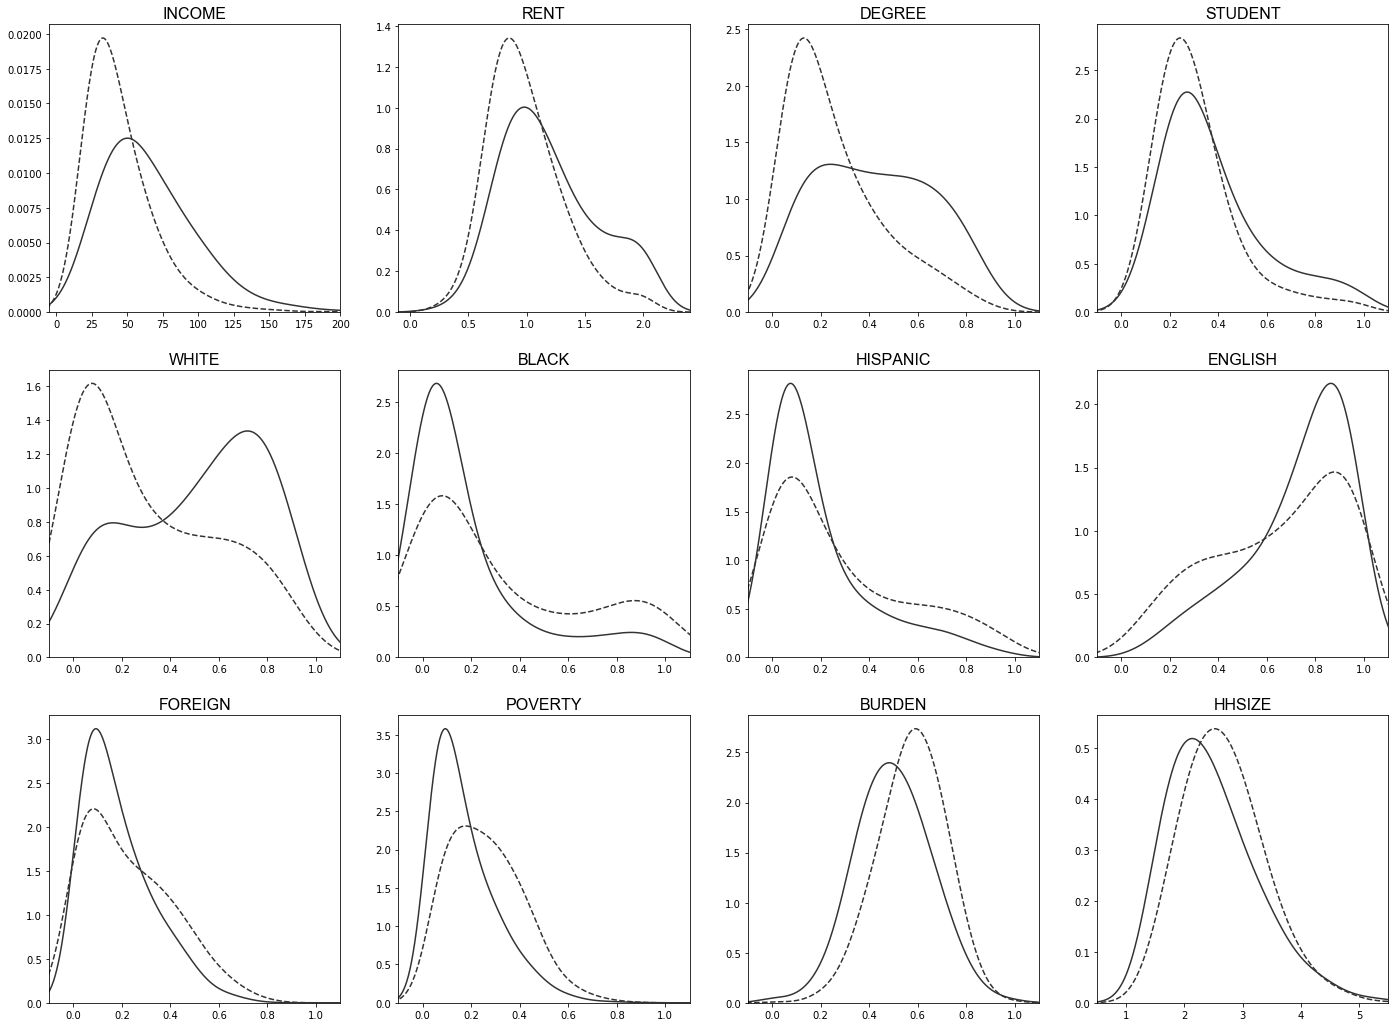

In [14]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*size, nrows*size), squeeze=False)
axes = [item for sublist in axes for item in sublist]
for ax, (name, var, (xmin, xmax)) in zip(axes, cols):    
    ax = over[var].plot.kde(ax=ax, c=c, alpha=a, lw=lw, ls='-', bw_method=bw)
    ax = under[var].plot.kde(ax=ax, c=c, alpha=a, lw=lw, ls='--', bw_method=bw)
    ax.set_ylim(bottom=0)
    ax.set_xlim((xmin, xmax))
    ax.set_title(name.upper(), fontdict={'family':'Arial', 'size':16})
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.savefig('images/fig_variable_distributions.png', bbox_inches='tight', dpi=200)    
plt.show()

In [15]:
group_white = df[df['prop_white'] > 0.5]
group_black = df[df['prop_black'] > 0.5]
group_hispanic = df[df['prop_hispanic'] > 0.5]
group_2034 = df[df['prop_20_34'] > 0.5]
group_inc_0_35 = df[df['med_income_k'] < 35]
group_inc_35_55 = df[(df['med_income_k'] >= 35) & (df['med_income_k'] <= 55)]
group_inc_55_up = df[df['med_income_k'] > 55]
group_degree = df[df['prop_bachelors_or_higher'] > 0.5]
group_student = df[df['prop_college_grad_student'] > 0.5]
group_poverty = df[df['prop_below_poverty'] > 0.25]
group_rent_900 = df[df['median_gross_rent_k'] < 0.9]
group_inc_900_1200 = df[(df['median_gross_rent_k'] >= 0.9) & (df['median_gross_rent_k'] <= 1.2)]
group_rent_1200 = df[df['median_gross_rent_k'] > 1.2]

groups = [('Income <$35k', group_inc_0_35),
          ('Income $35-55k', group_inc_35_55),
          ('Income >$55k', group_inc_55_up),
          ('Rent <$900', group_rent_900),
          ('Rent $900-1,200', group_inc_900_1200),
          ('Rent >$1,200', group_rent_1200),
          ('Majority w/ degree', group_degree),
          ('Majority student', group_student),
          ('Majority white', group_white),
          ('Majority black', group_black),
          ('Majority Hispanic', group_hispanic),
          ('Majority age 20-34', group_2034),
          ('Poverty rate >25%', group_poverty)]

stats = {}
for label, group in groups:
    stats[label] = {}
    stats[label]['Theoretical listings'] = group['proportionate_count_vacant'].sum() / df['proportionate_count_vacant'].sum()
    stats[label]['Empirical listings'] = group['clist_count'].sum() / df['clist_count'].sum()

df_stats = pd.DataFrame(stats).T.reindex(columns=['Theoretical listings', 'Empirical listings'])
df_stats = df_stats.reindex(labels=[label for label, group in groups])
df_stats

,Theoretical listings,Empirical listings
Income <$35k,0.332583,0.162438
Income $35-55k,0.337296,0.276319
Income >$55k,0.330112,0.561242
Rent <$900,0.378180,0.214532
"Rent $900-1,200",0.336118,0.306951
"Rent >$1,200",0.285479,0.476693
Majority w/ degree,0.283358,0.516983
Majority student,0.260347,0.412347
Majority white,0.393808,0.585432
Majority black,0.158861,0.065249


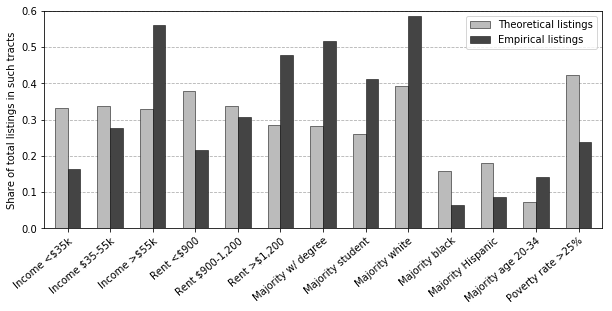

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = df_stats.plot(ax=ax, kind='bar', color=['#bbbbbb', '#444444'], width=0.6,
                   edgecolor='k', lw=0.5, hatch=None, legend=True, zorder=2)

ax.grid(True, axis='y', linestyle='--')
ax.set_xticklabels(df_stats.index, rotation=40, rotation_mode='anchor', ha='right')
ax.set_ylabel('Share of total listings in such tracts')
ax.set_ylim(top=0.6)

plt.savefig('images/fig_tract_shares.png', bbox_inches='tight', dpi=300) 
plt.show()

## Race

In [17]:
len(df)

12328

In [18]:
# in how many tracts is each race the majority?
cols = ['dummy_white_major', 'dummy_black_major', 'dummy_hispanic_major', 'dummy_asian_major']
df[cols].sum()

dummy_white_major       4868
dummy_black_major       2767
dummy_hispanic_major    2266
dummy_asian_major        231
dtype: int64

In [19]:
# in how many tracts is each race the plurality?
cols = ['dummy_white_plural', 'dummy_black_plural', 'dummy_hispanic_plural', 'dummy_asian_plural']
df[cols].sum()

dummy_white_plural       5819
dummy_black_plural       3140
dummy_hispanic_plural    2898
dummy_asian_plural        465
dtype: int64

In [20]:
# what proportion of tracts are over-represented?
df['is_over'] = df['bias_ratio_vacant'] > 1
round(df['is_over'].sum() / len(df), 4)

0.357

In [21]:
# what proportion of tracts with each of these races as the majority is over-represented?
white_tracts = df[df['dummy_white_major']==1]
white_odds = round(white_tracts['is_over'].sum() / len(white_tracts), 4)

asian_tracts = df[df['dummy_asian_major']==1]
asian_odds = round(asian_tracts['is_over'].sum() / len(asian_tracts), 4)

black_tracts = df[df['dummy_black_major']==1]
black_odds = round(black_tracts['is_over'].sum() / len(black_tracts), 4)

hisp_tracts = df[df['dummy_hispanic_major']==1]
hisp_odds = round(hisp_tracts['is_over'].sum() / len(hisp_tracts), 4)

print(white_odds, asian_odds, black_odds, hisp_odds)
print(round(white_odds / asian_odds, 4))
print(round(white_odds / black_odds, 4))
print(round(white_odds / hisp_odds, 4))

0.5173 0.3983 0.1887 0.2158
1.2988
2.7414
2.3971


Majority white tracts are overrepresented on Craigslist 2x as often as majority black tracts and 3x  as often as majority hispanic tracts.

In [22]:
# what pct of tracts have less than 25% the listings we'd expect proportionally?
df['very_under_rep'] = df['bias_ratio_vacant'] < 0.25
df['very_under_rep'].sum() / len(df)

0.21000973393900066

In [23]:
# what proportion of tracts with each of these races as the majority is very under-represented?
white_tracts = df[df['dummy_white_major']==1]
white_odds = round(white_tracts['very_under_rep'].sum() / len(white_tracts), 4)

asian_tracts = df[df['dummy_asian_major']==1]
asian_odds = round(asian_tracts['very_under_rep'].sum() / len(asian_tracts), 4)

black_tracts = df[df['dummy_black_major']==1]
black_odds = round(black_tracts['very_under_rep'].sum() / len(black_tracts), 4)

hisp_tracts = df[df['dummy_hispanic_major']==1]
hisp_odds = round(hisp_tracts['very_under_rep'].sum() / len(hisp_tracts), 4)

print(white_odds, asian_odds, black_odds, hisp_odds)

0.1113 0.1732 0.2725 0.3473


## Gini

In [24]:
# gini coefficient measures how evenly some value is distributed among a set of buckets
# we can measure how evenly listings are distributed among tracts
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return round((fair_area - area) / fair_area, 4)

In [25]:
# nationwide
print(gini(df['clist_count_vacant']))
print(gini(df['proportionate_count_vacant']))
print(gini(df['vacant_rental_units']))

0.7958
0.6966
0.5968


The proportionate_count is a function of per-city count_renter_occupied_units, but their gini coefficients don't match nationwide because proportionate_count is assigned as per-city proportions, not nationwide. See below: they match.

In [26]:
# now examine gini coefficients for each city
data = {}
for name, group in df.groupby('place_name'):
    
    data[name] = {'clist_gini' : gini(group['clist_count_vacant']),
                  'prop_gini' : gini(group['proportionate_count_vacant']),
                  'units_gini' : gini(group['vacant_rental_units'])}
    
ginis = pd.DataFrame(data).T
ginis['ratio'] = ginis['clist_gini'] / ginis['prop_gini']
ginis.sort_values(by='ratio', ascending=False).round(3)

,clist_gini,prop_gini,units_gini,ratio
"Hartford, CT",0.826,0.375,0.375,2.204
"Miami, FL",0.789,0.416,0.416,1.896
"Providence, RI",0.591,0.322,0.322,1.835
"St. Louis, MO",0.742,0.429,0.429,1.728
"Baltimore, MD",0.773,0.470,0.470,1.646
"Cleveland, OH",0.727,0.458,0.458,1.588
"Richmond, VA",0.719,0.465,0.465,1.545
"Chicago, IL",0.890,0.583,0.583,1.526
"Philadelphia, PA",0.756,0.497,0.497,1.521
"Washington, DC",0.693,0.468,0.468,1.481


Higher gini coefficient for actual craigslist listings suggests they are more concentrated into fewer tracts than a proportional distribution would be.

## *t*-tests and effect sizes for significant differences in variables

Divide the data into two subsets: overrepresented and underrepresented, then test if variables' means differ significantly between them.

In [27]:
def significance_05(p):
    if p <= 0.05:
        return '*'
    else:
        return '~~'
    
def significance_05_01_001(p):
    if p <= 0.001:
        return '***'
    if p <= 0.01:
        return '**~~'
    elif p <= 0.05:
        return '*~~~~'
    else:
        return '~~~~~~'

In [28]:
# effect size: as cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return d

def test_differences(subset1, subset2, variables):
    test_results = {}
    for var in variables:
        a = subset1[var]
        b = subset2[var]
        t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
        diff = subset1[var].mean() - subset2[var].mean()
        d_value = cohen_d(x=a, y=b)
        test_results[var] = {'diff_mean' : '{:.3f}{}'.format(diff, significance_05(p_value)),
                             't_stat' : round(t_statistic, 2),
                             'p_val' : round(p_value, 3),
                             'cohen_d' : round(d_value, 2)}
    
    return test_results

In [29]:
# divide dataset into overrepresented tracks and not overrepresented
over = df[df['bias_ratio_vacant'] > 1]
under = df[df['bias_ratio_vacant'] < 1]
print(len(over), len(under))

4401 6787


In [30]:
# variables' effect sizes between over and underrepresented tracts
results = test_differences(over, under, predictors_ttest_all)
effect_sizes = pd.DataFrame(results).T.sort_values('cohen_d', ascending=False)
effect_sizes = effect_sizes.reindex(columns=['cohen_d', 'diff_mean'])
effect_sizes

,cohen_d,diff_mean
prop_bachelors_or_higher,0.79,0.169*
med_income_k,0.74,20.734*
prop_white,0.72,0.203*
median_gross_rent_k,0.58,0.206*
prop_college_grad_student,0.39,0.074*
med_home_value_k,0.35,79.116*
prop_single_fam_detached,0.31,0.096*
prop_english_only,0.31,0.077*
med_rooms_in_house,0.29,0.324*
prop_nonrelatives_household,0.23,0.014*


In [31]:
#effect_sizes['cohen_d'] = effect_sizes['cohen_d'].map(lambda x: '{:.2f}'.format(x))
#print(effect_sizes.to_latex())

"Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically signficant."

Perhaps we can interpret small-medium effect size as absolute value 0.3 <= x < 0.5?

d is not affected by units/sizes. So income and income_k will have same d.

In [32]:
# look at some smaller subset of key variables of interest, per city
city_results = {}
city_results_str = {}
for city, group in df.groupby('place_name'):
    group_over = group[group['bias_ratio_vacant'] > 1]
    group_under = group[group['bias_ratio_vacant'] < 1]
    group_results = test_differences(group_over, group_under, predictors_ttest_city)
    city_results[city] = {k:v['cohen_d'] for k, v in group_results.items()}
    d_str = {k:'{:.2f}{}'.format(v['cohen_d'], significance_05(v['p_val'])) for k, v in group_results.items()}
    city_results_str[city] = d_str

In [33]:
city_effect_sizes = pd.DataFrame(city_results).T
city_effect_sizes.index = city_effect_sizes.index.map(lambda x: x.split(', ')[0])
city_effect_sizes.sort_values(by='med_income_k', ascending=False).head(12)

,med_income_k,median_gross_rent_k,prop_20_34,prop_bachelors_or_higher,prop_below_poverty,prop_college_grad_student,prop_english_only,prop_white,renter_household_size
Miami,1.68,1.54,0.90,2.08,-1.37,1.26,0.17,2.00,-1.18
Chicago,1.51,1.33,1.14,1.62,-0.89,1.04,0.32,1.36,-0.82
Louisville,1.15,0.79,0.09,0.88,-0.88,0.46,0.14,0.86,-0.31
New Orleans,1.14,1.11,0.55,1.51,-0.90,0.86,-0.28,1.59,-0.36
Washington,1.06,1.23,0.81,1.34,-0.91,0.82,-0.77,1.15,-0.52
San Diego,1.02,1.04,-0.41,0.72,-0.81,-0.12,0.40,0.43,0.06
San Antonio,1.01,0.84,-0.32,0.72,-0.71,0.04,0.87,0.80,0.05
Las Vegas,1.01,1.13,-0.57,0.69,-0.81,0.18,0.73,0.65,0.39
Houston,0.99,0.95,0.01,0.99,-0.98,0.50,0.73,1.04,-0.44
Columbus,0.92,0.83,-0.18,0.72,-0.79,-0.03,0.38,0.72,-0.18


In [34]:
city_effect_sizes_str = pd.DataFrame(city_results_str).T
city_effect_sizes_str.index = city_effect_sizes_str.index.map(lambda x: x.split(', ')[0])
#print(city_effect_sizes_str.to_latex())

In [35]:
var = 'med_home_value_k'
place = 'Miami, FL'
print(over[over['place_name']==place][var].mean())
print(under[under['place_name']==place][var].mean())

370.9857142857143
162.54324324324324


## Estimate regression models to predict Craigslist over- or under-representation

In [36]:
df['proportionate_count_vacant'].head()

tract
01073000100    0.629666
01073000300    2.040526
01073000400    0.643179
01073000500    1.619957
01073000700    1.125308
Name: proportionate_count_vacant, dtype: float64

In [37]:
# create design matrix containing predictors (drop nulls), and a response variable vector
X = df[predictors_model + city_dummies].dropna()
y = df.loc[X.index]['bias_log_vacant']

In [38]:
# estimate a model across the full data set (all cities)
Xc = add_constant(X)
model = sm.OLS(y, Xc)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        bias_log_vacant   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     151.1
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:59:40   Log-Likelihood:                -17882.
No. Observations:               12224   AIC:                         3.590e+04
Df Residuals:                   12155   BIC:                         3.641e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [39]:
# white effect depends on income
for inc_k in [10, 50, 100]:
    wht_B = result.params['prop_white'] + np.log(inc_k) * result.params['prop_white*income_log']
    print(inc_k, '\t', round(wht_B, 3))

10 	 0.076
50 	 -0.47
100 	 -0.706


In [40]:
# income effect depends on white
for wht in [0.1, 0.5, 0.9]:
    inc_B = result.params['med_income_k_log'] + wht * result.params['prop_white*income_log']
    print(round(wht, 1), '\t', round(inc_B, 3))

0.1 	 0.33
0.5 	 0.194
0.9 	 0.058


The marginal effect of income on representation depends on racial composition. With a 10% white population, a 1% increase in median income increases representation by 0.33%. With a 90% white population, a 1% increase in median income increases it by only 0.06%. Similarly, in impoverished tracts, whiteness has a more positive effect: when median income is \$10,000, a 1 pp increase in white proportion increases representation by 0.08%. But when median income is \$100,000, a 1 pp increase in white proportion decreases it by 0.71%.

In [41]:
# single column version of results    
results = pd.DataFrame({'params' : result.params,
           'se' : result.bse,
           'p' : result.pvalues})

results['se'] = results['se'].map(lambda x: '{:.3f}'.format(x))
results['sig'] = results['p'].map(lambda p: significance_05_01_001(p))
results['params'] = results['params'].map(lambda x: '{:.3f}'.format(x))
results['params'] = results.apply(lambda row: '{}{}'.format(row['params'], row['sig']), axis=1)
results.index = results.index.map(lambda x: x.split(',')[0].replace('Q(\'', ''))
results = results.reindex(columns=['params', 'se'])
results.head()
#print(results.to_latex())

,params,se
const,-1.410***,0.327
count_rental_units_k,-0.098***,0.020
rental_vacancy_rate,-11.482***,0.165
prop_same_residence_year_ago,-0.408**~~,0.147
distance_to_center_km_log,-0.118***,0.020


^^ if we get warnings about multicollinearity, but have good VIF scores and significant variables, then check a standardized regression (below) to see if it's just scaling or the intercept/constant causing it (intercept shouldn't cause high condition number if we center/standardize our predictors). A high condition number indicates multicollinearity. Rule of thumb, you want this to be below ~20.

durbin-watson tests for autocorrelation. a value around 1.5 to 2.5 is considered fine.

omnibus tests for normality of residuals; if prob < 0.05, we reject the null hypothesis that they are normally distributed. skew and kurtosis describe their distribution.

jarque-bera tests for normality of residuals; if prob < 0.05, we reject the null hypothesis that they are normally distributed

Interaction term shows that the positive effect of income matters less as tract gets whiter and that the positive effect of white matters less as tract gets richer.

In [42]:
# estimate a standardized model across the full data set (all cities)
y_stdrd = pd.Series(data=zscore(y), index=y.index, name=y.name)
X_stdrd = pd.DataFrame(data=zscore(X), index=X.index, columns=X.columns)
Xc_stdrd = add_constant(X_stdrd)
model_stdrd = sm.OLS(y_stdrd, Xc_stdrd)
result_stdrd = model_stdrd.fit()
print(result_stdrd.summary())

                            OLS Regression Results                            
Dep. Variable:        bias_log_vacant   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     151.1
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:59:40   Log-Likelihood:                -13601.
No. Observations:               12224   AIC:                         2.734e+04
Df Residuals:                   12155   BIC:                         2.785e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [43]:
#print(result_stdrd.summary().as_latex())

## Regression Diagnostics

In [44]:
# condition number to test for multicollinearity
# rule of thumb, you want this below 20
np.linalg.cond(model_stdrd.exog)

35.718281566015285

In [45]:
# plot observed (y-axis) vs fitted (x-axis)
observed = model.endog #actual response var
fitted = result.fittedvalues #predicted response var

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=fitted, y=observed, s=0.2)
ax.set_xlabel('fitted')
ax.set_ylabel('observed')
ax.set_title('actual vs predicted')

# draw a 45° y=x line
ax.set_xlim((min(np.append(observed, fitted)), max(np.append(observed, fitted))))
ax.set_ylim((min(np.append(observed, fitted)), max(np.append(observed, fitted))))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', c='k', alpha=0.5)

fig.savefig('images/diagnostic_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.close()

In [46]:
# standardized residuals: the internally studentized residuals
resids_stud = result.get_influence().resid_studentized_internal

In [47]:
# residuals plot for heteroskedasticity
# want this to look like a random point pattern with no discernable trend
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=result.fittedvalues, y=resids_stud, s=0.2)
ax.axhline(y=0, ls='--', c='k', alpha=0.5)
ax.set_title('residuals vs fitted plot')
ax.set_xlabel('fitted values')
ax.set_ylabel('standardized residuals')

fig.savefig('images/diagnostic_residuals_vs_fitted.png', dpi=300, bbox_inches='tight')
plt.close()

In [48]:
# scale-location plot (aka spread-location plot)
# want this to look like a random point pattern with no discernable trend
resids_stud_abs_sqrt = np.sqrt(np.abs(resids_stud))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=result.fittedvalues, y=resids_stud_abs_sqrt, s=0.2)
ax.set_title('scale-location plot')
ax.set_xlabel('fitted values')
ax.set_ylabel('square-root absolute standardized residuals ')

fig.savefig('images/diagnostic_scale_location.png', dpi=300, bbox_inches='tight')
plt.close()

In [49]:
# are residuals approximately normally distributed?
# null hypothesis is normal dist, p-value < 0.05 means reject null
# typically want skew and kurtosis to be within -2 to 2
# but with sufficiently large sample size, we'll always reject the null
jb, jb_p, skew, kurtosis = sms.jarque_bera(resids_stud)
print([round(x, 3) for x in [jb, jb_p, skew, kurtosis]])

[945.091, 0.0, 0.517, 3.887]


In [50]:
# are residuals approximately normally distributed?
# visuals can be more useful than test-statistics
fig, ax = plt.subplots(figsize=(6, 6))
ax = pd.Series(resids_stud).hist(bins=30, ax=ax)
ax.set_title('standardized residuals histogram')
fig.savefig('images/diagnostic_residuals_histogram.png', dpi=300, bbox_inches='tight')
plt.close()

In [51]:
# are residuals approximately normally distributed?
# you want the points to tightly follow the line
# the hist above and qq plot below are ok, not terrible
fig, ax = plt.subplots(figsize=(6, 6))
fig = sm.qqplot(resids_stud, line='45', ax=ax)
ax.set_title('normal probability plot of the standardized residuals')
fig.savefig('images/diagnostic_residuals_qq_plot.png', dpi=300, bbox_inches='tight')
plt.close()

In [52]:
# create figure and axes
n = len(predictors_model)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

resids_stud = result.get_influence().resid_studentized_internal

# for each axis and variable, scatterplot the resids
for ax, var in zip(axes, sorted(predictors_model)):
    ax.scatter(x=X[var], y=resids_stud, s=0.2)
    ax.set_xlabel(var)
    ax.set_ylabel('standardized residuals')

# save to disk and show
fig.savefig('images/scatter_resids_vs_predictors.jpg', bbox_inches='tight', dpi=150)
plt.close()

## Regression model for just one city

In [53]:
# subset data for a single city
place_name = 'New York, NY'
df_city = df[df['place_name']==place_name]
print(sum(df_city['bias_ratio_vacant']>1), sum(df_city['bias_ratio_vacant']<=1))

480 1632


In [54]:
X_city = df_city[predictors_model]
print(len(X_city))
X_city = X_city.dropna()
y_city = df_city.loc[X_city.index]['bias_log_vacant']
print(len(X_city))
Xc_city = add_constant(X_city)

2112
2097


In [55]:
# estimate a model for this single city
model_city = sm.OLS(y_city, Xc_city)
result_city = model_city.fit()
print(result_city.summary())

                            OLS Regression Results                            
Dep. Variable:        bias_log_vacant   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     100.4
Date:                Fri, 06 Apr 2018   Prob (F-statistic):          1.32e-276
Time:                        20:59:45   Log-Likelihood:                -2361.8
No. Observations:                2097   AIC:                             4764.
Df Residuals:                    2077   BIC:                             4877.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Logit models

In [56]:
X_logit = df[predictors_model]
print(len(X_logit))
X_logit = X_logit.dropna()
y_logit = df.loc[X_logit.index]['is_over']
print(len(X_logit))
Xc_logit = add_constant(X_logit)

12328
12224


In [57]:
%%time
# predict whether or not tract is overrepresented on craigslist (yes/no)
#model_logit = sm.Logit(y_logit, Xc_logit)
#result_logit = model_logit.fit()
#print(result_logit.summary())

Wall time: 0 ns


## Dimensionality reduction

### PCA with the reduced set of predictors

In [58]:
X = df[predictors_model].dropna()#.drop(columns=['white:income'])
X = pd.DataFrame(scale(X.values), columns=X.columns)

In [59]:
# n dimensions
n = 6
pca = PCA(n_components=n)
pca.fit(X=X)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [60]:
# amount of variance that each component explains
pca.explained_variance_ratio_

array([0.26476843, 0.18830119, 0.13634107, 0.08146372, 0.06241728,
       0.05762267])

In [61]:
# cumulative variance explained
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))

array([0.265, 0.453, 0.589, 0.67 , 0.732, 0.79 ])

In [62]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(pca.components_, columns=X.columns, index=labels).T.sort_values('PC1', ascending=False).round(3)

,PC1,PC2,PC3,PC4,PC5,PC6
prop_white*income_log,0.401,-0.150,-0.022,0.087,0.051,0.126
prop_bachelors_or_higher,0.400,-0.023,-0.079,-0.108,-0.040,-0.091
prop_white,0.396,-0.109,-0.008,0.114,0.079,0.161
med_income_k_log,0.296,-0.280,-0.184,-0.049,-0.131,-0.159
prop_college_grad_student,0.269,0.277,-0.058,-0.120,-0.058,-0.129
median_gross_rent_k,0.211,-0.196,-0.274,-0.206,-0.215,-0.297
prop_english_only,0.186,-0.015,0.517,0.011,-0.147,-0.123
prop_20_34,0.159,0.393,-0.156,0.027,-0.261,-0.129
prop_65_older,0.086,-0.197,0.176,-0.257,0.578,0.135
count_rental_units_k,0.039,0.306,-0.157,-0.073,0.360,-0.312


### Factor analysis with the reduced set of predictors

In [63]:
# n factors
n = 6
fa = FactorAnalysis(n_components=n, max_iter=5000)
fa.fit(X=X)

FactorAnalysis(copy=True, iterated_power=3, max_iter=5000, n_components=6,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [64]:
labels = ['Fac{}'.format(i+1) for i in range(n)]
pd.DataFrame(fa.components_, columns=X.columns, index=labels).T.sort_values('Fac1', ascending=False).round(3)

,Fac1,Fac2,Fac3,Fac4,Fac5,Fac6
prop_white,0.999,-0.015,0.006,0.015,-0.001,0.004
prop_white*income_log,0.988,-0.008,-0.077,-0.098,0.001,-0.017
prop_bachelors_or_higher,0.717,-0.005,0.125,-0.551,-0.121,-0.168
med_income_k_log,0.607,0.183,-0.358,-0.616,0.068,-0.009
median_gross_rent_k,0.348,0.244,-0.220,-0.653,-0.023,0.166
prop_english_only,0.343,-0.869,0.011,-0.036,0.153,-0.110
prop_college_grad_student,0.336,-0.021,0.650,-0.321,-0.086,-0.045
med_rooms_in_house,0.208,-0.244,-0.692,-0.031,0.435,-0.030
prop_65_older,0.206,-0.185,-0.360,0.057,-0.456,-0.196
prop_20_34,0.143,0.108,0.884,-0.250,0.177,0.127
